In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from datetime import datetime

from datasets import HousingDataset
from model import Model
from utils import Select, CustomScale

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [3]:
mean=np.array([1377, 1354, 1381, 2356])
std=np.array([540, 398, 327, 515])

upperbound = mean + 3 * std
SCALE = upperbound[:, np.newaxis, np.newaxis]

norm_mean = mean / upperbound
norm_std = std / upperbound
    
transformations = [
    transforms.CenterCrop(size=(32, 32)), 
    CustomScale(scale=1/SCALE, clamp=(0, 1.0)),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    Select(dim=-3, indices=[0,1,2]),
]
transform = transforms.Compose(transformations)

reverse_transform = transforms.Normalize(mean=-norm_mean[:3]/norm_std[:3], std=1/norm_std[:3]/SCALE)

In [4]:
train_set = HousingDataset("/atlas/u/erikrozi/housing_event_pred/data/train_seasonal_eff.csv", transform=transform)
print(len(train_set))
val_set = HousingDataset("/atlas/u/erikrozi/housing_event_pred/data/val_seasonal_eff.csv", transform=transform)
print(len(val_set))

25071
1411


In [8]:
# toy_indices = list(np.random.choice(np.arange(len(train_set)), size=(100,), replace=False))
# train_set = torch.utils.data.Subset(train_set, toy_indices)
# val_indices = list(np.random.choice(np.arange(len(val_set)), size=(100,), replace=False))
# val_set = torch.utils.data.Subset(val_set, val_indices)

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

In [6]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16,32,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.BatchNorm2d(32),
    torch.nn.Conv2d(32,64,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64,128,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.BatchNorm2d(128),
).to(device=device)

# torchvision.models.resnet18(pretrained=True).to(device=device)
# encoder.layer4 = torch.nn.Identity()
# encoder.avgpool = torch.nn.Identity()
# encoder.fc = torch.nn.Identity()

# import sys
# sys.path.append("../housing_event_pred/models")
# import resnet_cifar
# encoder = resnet_cifar.ResNet18(img_channels=3).to(device=device)
# encoder.avgpool = torch.nn.Identity()
# encoder.fc = torch.nn.Identity()

In [7]:
model = Model(encoder).to(device=device).train()

In [13]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
now = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')
writer = SummaryWriter(log_dir=f'runs/exp_{now}')
num_epochs = 2
idx = 0
loss_history = [] # Train losses over batches
train_loss_history = [] # Train losses over epochs
val_loss_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []
    
    model.train()
    for i, batch in enumerate(train_loader):
        idx += 1
        img_start = batch["image_start"].to(device=device).float()
        img_end = batch["image_end"].to(device=device).float()
        img_sample = batch["image_sample"].to(device=device).float()
        label = batch["label"].float().to(device=device).unsqueeze(1)
        
        optimizer.zero_grad()
        pred = model(img_start, img_end, img_sample)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        writer.add_scalar('Loss/batch/train', loss, idx)
        loss_history.append(loss)
        epoch_losses.append(loss)
        epoch_accuracies.append(np.mean(1 * ((pred > 0.5) == label).detach().cpu().numpy()))
        if idx % 10 == 0:
            print(f"Epoch {epoch}, batch {idx}, loss = {loss}")

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss_history.append(epoch_loss)
    writer.add_scalar('Loss/epoch/train', epoch_loss, epoch)
    
    epoch_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
    train_acc_history.append(epoch_accuracy)
    writer.add_scalar('Accuracy/epoch/train', epoch_accuracy, epoch)
    
    print(f"Epoch {epoch} loss = {epoch_loss} accuracy = {epoch_accuracy}")
    
    # Validation
    val_predictions = []
    val_labels = []
    model.eval()
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            img_start = batch["image_start"].to(device=device).float()
            img_end = batch["image_end"].to(device=device).float()
            img_sample = batch["image_sample"].to(device=device).float()
            label = batch["label"].float().to(device=device)

            pred = model(img_start, img_end, img_sample).flatten()
            val_predictions.append(pred.detach().cpu().numpy())
            val_labels.append(label.flatten().cpu().numpy())
    val_predictions = np.concatenate(val_predictions)
    val_labels = np.concatenate(val_labels)
    val_loss = criterion(torch.FloatTensor(val_predictions), torch.FloatTensor(val_labels))
    val_loss_history.append(val_loss)
    writer.add_scalar('Loss/epoch/val', val_loss, epoch)
    
    val_accuracy = np.sum((val_predictions > 0.5) == val_labels.astype(int)) / len(val_labels)
    val_acc_history.append(val_accuracy)
    writer.add_scalar('Accuracy/epoch/val', val_loss, epoch)
    
    print(f"Epoch {epoch} val loss = {val_loss} accuracy = {val_accuracy}")

Epoch 0 loss = 2.0016391703060696 accuracy = 7.142857142857143
Epoch 0 val loss = 0.7051939964294434 accuracy = 0.43
Epoch 1, batch 10, loss = 0.7309736013412476
Epoch 1 loss = 0.6968844277518136 accuracy = 8.285714285714286
Epoch 1 val loss = 0.6796861886978149 accuracy = 0.54


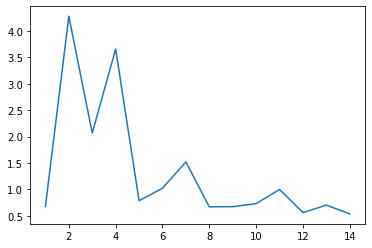

In [15]:
plt.plot(np.arange(1, len(loss_history) + 1), loss_history)
plt.show()

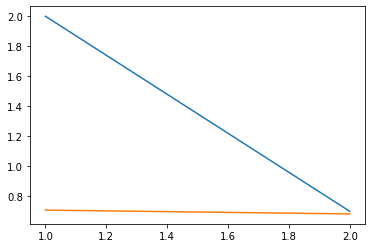

In [17]:
plt.plot(np.arange(1, len(train_loss_history) + 1), train_loss_history)
plt.plot(np.arange(1, len(val_loss_history) + 1), val_loss_history)
plt.show()

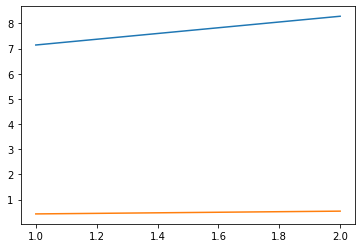

In [18]:
plt.plot(np.arange(1, len(train_acc_history) + 1), train_acc_history)
plt.plot(np.arange(1, len(val_acc_history) + 1), val_acc_history)
plt.show()

# Evaluate model

In [12]:
def predict(model, dset, loops=1):
    model.eval()
    dloader = torch.utils.data.DataLoader(dset, batch_size=10, shuffle=False)
    predictions = []
    labels = []
    for _ in range(loops):
        for i, batch in enumerate(dloader):
            with torch.no_grad():
                img_start = batch["image_start"].to(device=device).float()
                img_end = batch["image_end"].to(device=device).float()
                img_sample = batch["image_sample"].to(device=device).float()
                label = batch["label"].float().to(device=device)

                pred = model(img_start, img_end, img_sample).flatten()
                predictions.append(pred.detach().cpu().numpy())
                labels.append(label.flatten().cpu().numpy())
    return np.concatenate(predictions), np.concatenate(labels).astype(int)

In [13]:
predictions, labels = predict(model, val_set, loops=10)

KeyboardInterrupt: 

In [ ]:
predictions = (predictions > 0.5)
accurate = np.sum(labels == predictions)
total = len(labels)
print(f"Accuracy {accurate} / {total} = {accurate/total}")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))